In [1]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import rtree, pygeos, fiona
import netCDF4
import xarray as xr
import dask

/Users/etriesch/.pyenv/versions/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_raw_path = repo_path / 'data/raw/'
data_clean_path = repo_path / 'data/clean/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'

In [3]:
# Northeast Pacific mask
p_min_lat, p_max_lat = 29, 48
p_min_lon, p_max_lon = -140, -116
p_min_y, p_max_y = 996, 1460
p_min_x, p_max_x = 940, 1832
#Northwest Atlantic mask
a_min_lat, a_max_lat = 20, 48
a_min_lon, a_max_lon = -97, -60
a_min_y, a_max_y = 996, 1675
a_min_x, a_max_x = 1960, 2884
# Monterrey desal mask
ca_min_lat, ca_max_lat = 33.48, 39.48
ca_min_lon, ca_max_lon = -125.48, -119.48
# Texas desal mask
tx_min_lat, tx_max_lat = 25.57, 31.57
tx_min_lon, tx_max_lon = -98.21, -92.21
# NH desal mask
nh_min_lat, nh_max_lat = 39.38, 45.38
nh_min_lon, nh_max_lon = -73.50, -67.50

# Read in data

In [4]:
# get filenames
temp_path = repo_path / 'data/raw/sst_modis/'
t_files = [f for f in os.listdir(temp_path) 
           if f.endswith('.nc')]
t_files.sort()
print('files to read:', len(t_files))

files to read: 71


In [5]:
# read in data
t_pac = pd.DataFrame()
t_atl = pd.DataFrame()
# for f in tqdm(t_files[0:12]):
for f in tqdm(t_files):
    t = xr.open_dataset(temp_path / f)
    # reset lat/lon
    t['lat'] = t.lat.to_dataframe().reset_index(drop=True).index
    t['lon'] = t.lon.to_dataframe().reset_index(drop=True).index
    # create pacific and atlantic masks
    p_mask_lon = (t.lon >= p_min_x) & (t.lon <= p_max_x)
    p_mask_lat = (t.lat >= p_min_y) & (t.lat <= p_max_y)
    a_mask_lon = (t.lon >= a_min_x) & (t.lon <= a_max_x)
    a_mask_lat = (t.lat >= a_min_y) & (t.lat <= a_max_y)
    pac = t.where(p_mask_lon & p_mask_lat, drop=True)
    atl = t.where(a_mask_lon & a_mask_lat, drop=True)
    # convert to dataset and append
    pac = pac.sst.to_dataframe().reset_index()
    pac['date_string'] = f[11:19]
    atl = atl.sst.to_dataframe().reset_index()
    atl['date_string'] = f[11:19]
    t_pac = pd.concat([pac, t_pac])
    t_atl = pd.concat([atl, t_atl])

100%|███████████████████████████████████████████| 71/71 [08:53<00:00,  7.52s/it]


# Clean and subset

In [6]:
# make single df for cleaning
t_pac['pacific'] = True
t_atl['pacific'] = False
t_raw = pd.concat([t_pac, t_atl]).reset_index(drop=True)

In [7]:
t_raw = t_raw.rename(columns={'lon':'x', 'lat':'y'})
t_raw['date'] = pd.to_datetime(t_raw.date_string)
t_raw['year'] = t_raw.date.dt.year

In [8]:
# clean chlorophyl values
# set outlier as 5 times the 75th percentile
PCTL, OUTL = 0.75, 10
pctl_colname = 'pctl'+str(int(PCTL*100))
t_raw[pctl_colname] = t_raw.groupby(['year', 'pacific'])['sst'].transform(lambda x: x.quantile(PCTL))
print('Outlier threshold:\n', (OUTL * t_raw[pctl_colname]).drop_duplicates().values)
t_raw['drop_outlier'] = t_raw.sst >= OUTL * t_raw[pctl_colname]
print(f'Outliers dropped (Pacific): {t_raw.loc[t_raw.pacific & t_raw.drop_outlier].shape[0]} ({t_raw.loc[t_raw.pacific & t_raw.drop_outlier].shape[0] / t_raw.loc[t_raw.pacific].shape[0]:0.2%})')
print(f'Outliers dropped (Atlantic): {t_raw.loc[~t_raw.pacific & t_raw.drop_outlier].shape[0]} ({t_raw.loc[~t_raw.pacific & t_raw.drop_outlier].shape[0] / t_raw.loc[~t_raw.pacific].shape[0]:0.2%})')

Outlier threshold:
 [188.65    190.59999 190.5     184.75    188.69998 189.25    281.7
 282.69998 283.      281.35    279.35    281.95   ]
Outliers dropped (Pacific): 0 (0.00%)
Outliers dropped (Atlantic): 0 (0.00%)


In [9]:
# drop outliers
t_raw = t_raw.loc[~t_raw.drop_outlier]

In [10]:
# drop any point that doesn't have more than N observations in a year
# get mean, max, std chlorophyll per year at each location
OBS_THRESHOLD = 2
t_raw['drop_low_annual_count'] = t_raw.groupby(['pacific', 'x', 'y', 'year'])['sst'].transform('count') < OBS_THRESHOLD
print(f'Low annual count dropped (Pacific): {t_raw.loc[t_raw.pacific & t_raw.drop_low_annual_count].shape[0]} ({t_raw.loc[t_raw.pacific & t_raw.drop_low_annual_count].shape[0] / t_raw.loc[t_raw.pacific].shape[0]:0.2%})')
print(f'Low annual count dropped (Atlantic): {t_raw.loc[~t_raw.pacific & t_raw.drop_low_annual_count].shape[0]} ({t_raw.loc[~t_raw.pacific & t_raw.drop_low_annual_count].shape[0] / t_raw.loc[~t_raw.pacific].shape[0]:0.2%})')

Low annual count dropped (Pacific): 13898789 (47.14%)
Low annual count dropped (Atlantic): 18376329 (41.15%)


In [11]:
# drop missing obs
t = t_raw.loc[~t_raw.drop_low_annual_count].reset_index(drop=True)

### Interpolate missing values linearly

In [12]:
# generate date range for each latitude
t_date_range = t.date.agg(['min','max'])
dates = pd.DataFrame({'date': pd.date_range(t_date_range[0], t_date_range[1], freq='MS')})
dates['tmp'] = 1
latlons = t.groupby(['pacific', 'x', 'y'])['date'].agg(['min','max']).reset_index()
latlons['tmp'] = 1
dates_pac = pd.merge(left=latlons.loc[latlons.pacific], right=dates, how='left', on=['tmp'])
dates_pac = dates_pac.loc[(dates_pac.date >= dates_pac['min']) & (dates_pac.date <= dates_pac['max'])] #subset to appropriate date range
dates_atl = pd.merge(left=latlons.loc[~latlons.pacific], right=dates, how='left', on=['tmp'])
dates_atl = dates_atl.loc[(dates_atl.date >= dates_atl['min']) & (dates_atl.date <= dates_atl['max'])] #subset to appropriate date range
dates = pd.concat([dates_pac, dates_atl]).reset_index(drop=True)

In [13]:
# merge in missing dates
t = pd.merge(left=t, right=dates, how='right', on=['pacific', 'x', 'y', 'date'])
t['int'] = t.sst.isna()
print(f'interpolating {t.int.sum()} months out of {t.shape[0]}, ({(t.int.sum())/t.shape[0]: 0.2%})')

interpolating 724561 months out of 41913305, ( 1.73%)


In [14]:
# linear interpolation of points: sort values, interpolate linearly
t = t.sort_values(['pacific', 'x', 'y', 'date']).reset_index(drop=True)
t['sst_int'] = t.sst.interpolate(method='linear')
t['sst_cln'] = np.where(t.int, t.sst_int, t.sst)
# replace with nan if data from previous group
t['count'] = t.groupby(['x', 'y']).cumcount()
t['sst_cln'] = np.where((t['count'] == 0) & (t.int), np.nan, t.sst_cln)

In [15]:
t = t[['pacific', 'x', 'y', 'date', 'sst_cln', 'int']]
t['year'] = t.date.dt.year

# Create analytical columns

In [16]:
# get mean, max, std chlorophyll per year at each location
t_s = t.groupby(['pacific', 'x', 'y', 'year'])['sst_cln'].agg(['count', 'std', 'max', 'mean']).reset_index()
# drop any half years
OBS_THRESHOLD = 4
print(f"Dropping {(t_s['count'] < OBS_THRESHOLD).sum()} ({(t_s['count']<OBS_THRESHOLD).sum()/t_s.shape[0]:0.2%}) point-years that have less than {OBS_THRESHOLD} months of data (including interpolation)")
t_s = t_s.loc[t_s['count'] >= OBS_THRESHOLD]

Dropping 0 (0.00%) point-years that have less than 4 months of data (including interpolation)


In [17]:
# merge back onto full dataset
t_m = pd.merge(left=t, right=t_s, how='right', on=['pacific', 'x', 'y', 'year'])
t_annual = t_s

# Combine analysis datasets

In [18]:
# create lat/lon to x/y map
ll = xr.open_dataset(temp_path / t_files[0])

x = ll.lon.to_dataframe().reset_index(drop=True).index
lon = ll.coords['lon'].values
x_to_lon = pd.DataFrame({'x':x, 'lon':lon})

y = ll.lat.to_dataframe().reset_index(drop=True).index
lat = ll.coords['lat'].values
y_to_lat = pd.DataFrame({'y':y, 'lat':lat})

# merge onto dataset
t_summ_annual = pd.merge(left=t_s, right=x_to_lon, on='x')
t_summ_annual = pd.merge(left=t_summ_annual, right=y_to_lat, on='y')

In [19]:
t_summ = t_summ_annual.groupby(['pacific', 'lat', 'lon', 'x', 'y'])[['std', 'max', 'mean']].mean().reset_index()
print('Mean annualized data:', t_summ.shape[0])

Mean annualized data: 591753


# Write data to computer

In [20]:
filename = 'sst.csv'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

t_summ.to_csv(filepath, index=False)

In [21]:
filename = 'sst_annual.csv'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

t_summ_annual.to_csv(filepath, index=False)

In [30]:
# monthly, in chunks
t['month'] = t.date.dt.month
chunk_size: int = 5000000
# write chunks of chlor monthly to temporary location
for i in tqdm(range(0, t.shape[0], chunk_size)):
    chunk = t.iloc[i:i + chunk_size]
    filepath = data_clean_path / 'sst_monthly' / f'sst_monthly_{i}.csv.gz'
    filepath.parent.mkdir(parents=True, exist_ok=True)
    chunk.to_csv(filepath, index=False, compression='gzip')

100%|█████████████████████████████████████████████| 9/9 [14:32<00:00, 96.89s/it]


# Visualize

## temperature over time
Good indices: `142572`
look into: `1016367`

index: 35215


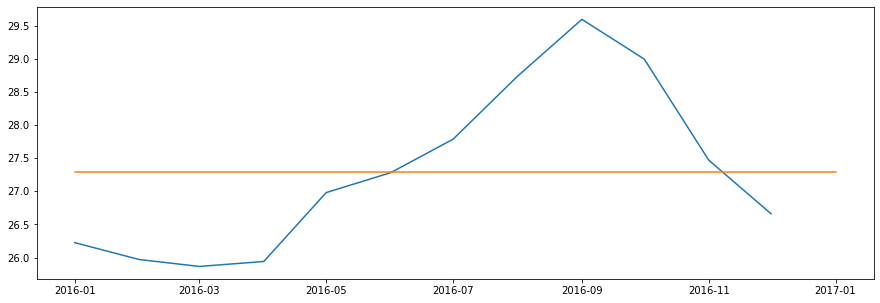

In [61]:
# Visualize chlorophll at lat/long over time
i = np.random.randint(0,t_summ.shape[0])
sub = t.loc[(t.x == t_summ.x.iloc[i]) & (t.y == t_summ.y.iloc[i])].sort_values('date')
# get annual mean
sub_m = t_summ_annual.loc[(t_summ_annual.x == t_summ.x.iloc[i]) & (t_summ_annual.y == t_summ.y.iloc[i])].sort_values('year')
sub_m = sub_m.append(sub_m.iloc[-1])
sub_m.loc[-1,'year'] = int(sub_m.loc[:,'year'].iloc[-1] + 1)
sub_m['date'] = pd.to_datetime(sub_m.year.astype(int).astype(str) + '-01-01')

fig, ax = plt.subplots(figsize=(15,5))
plt.plot(sub['date'], sub['sst_cln'])
# plt.hlines(y=sub.chlor_a_cln.mean(), xmin=sub.date.min(), xmax=sub.date.max(), color='red')
plt.step(sub_m['date'], sub_m['mean'], where='post')
# print info and chart
print('index:', i)
# print('location:', chl_m_s.pacific.iloc[i], round(chl_m_s.x.iloc[i], 4), round(chl_m_s.y.iloc[i], 4))
plt.show()

## Map of mean temperature

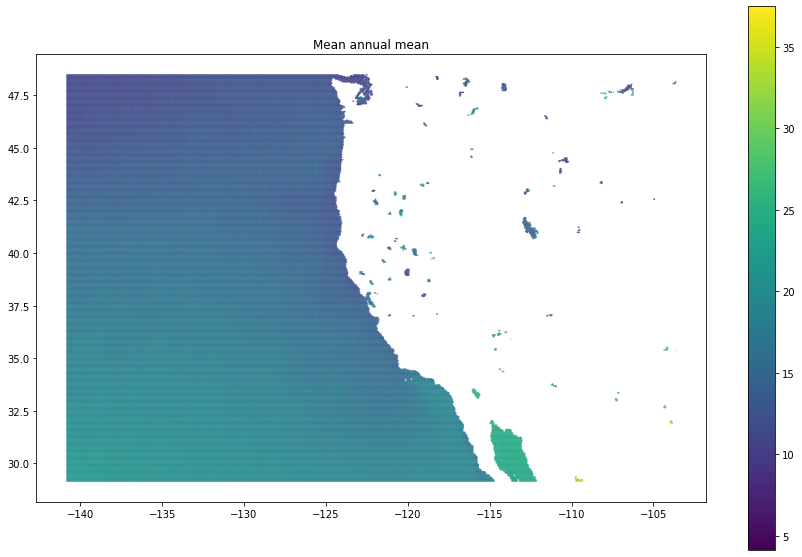

In [62]:
# Visualize
# mean temperature - pacific mean
geometry = [Point(xy) for xy in zip(t_summ['lon'], t_summ['lat'])]
gp = gpd.GeoDataFrame(t_summ, crs=geo_crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='mean', markersize=0.1, legend=True)
plt.title('Mean annual mean')
plt.show()

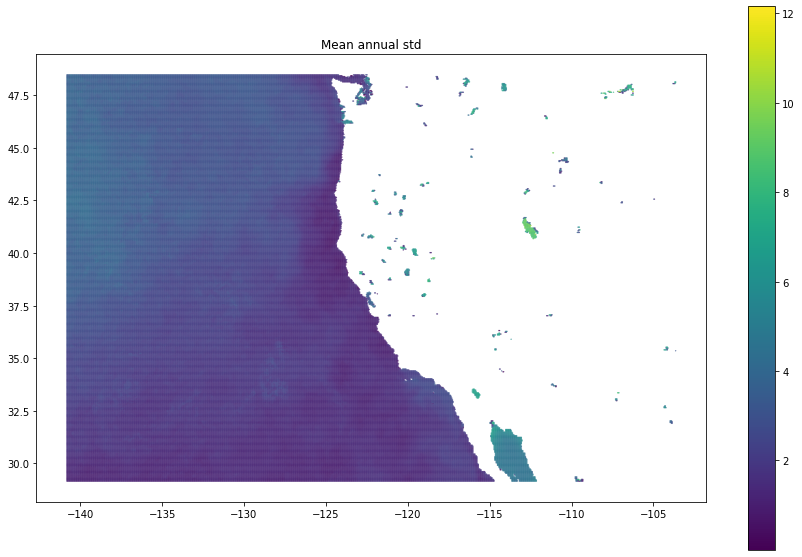

In [63]:
# Visualize
# mean temperature - pacific mean
geometry = [Point(xy) for xy in zip(t_summ['lon'], t_summ['lat'])]
gp = gpd.GeoDataFrame(t_summ, crs=geo_crs, geometry=geometry)
gp = gp.loc[gp.pacific]
fig,ax = plt.subplots(figsize=(15,10))
gp.plot(ax=ax, column='std', markersize=0.1, legend=True)
plt.title('Mean annual std')
plt.show()